**EJRECICIO PUNTUABLE.** crear en un notebook de jupyter un modelo basado en LSTMs para predecir el precio de la energía de cada una de las próximas 12 horas, del documento csv. que te adjunto. El entregable debe ser el fichero ipynb con las ejecuciones, los comentarios y las conclusiones.

Condiciones:

El KPI de medición de bondad del modelo es el MSE de las predicciones de las 12h próximas horas.

El dataset de test corresponde a los datos con índice 9000 y superior y debéis calcular el MSE con estos datos

Los datos con indices 0-9000 los podéis dividir en train i validación como queráis-

Importación de librerías

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.layers import Dropout
import matplotlib.pyplot as plt

**1. Carga de datos**

In [ ]:
# Load the dataset
data = pd.read_csv('energy_price_2022.csv')

**2. Preparación de datos**

Ajusta los nombres de las columnas y convierte el campo de fecha y hora al formato adecuado.

In [ ]:
# Adjust column names correctly and parse datetime
data.columns = ['date', 'UTC', 'Price']
data['date_UTC'] = data['date'] + ' ' + data['UTC']
data['date_UTC'] = pd.to_datetime(data['date_UTC'], format='%d/%m/%Y %H:%M')
data.drop(columns=['date', 'UTC'], inplace=True)
data.set_index('date_UTC', inplace=True)

**3.Creación de Características Desfasadas**  

Crea columnas de precios desfasados para las próximas 12 horas.

In [ ]:
# Create lagged features for the next 12 hours
for i in range(1, 13):
    data[f'Price_t+{i}'] = data['Price'].shift(-i)

data.dropna(inplace=True)

**4.Normalización de Datos**  
Normaliza los datos de precios usando MinMaxScaler.


In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

**5.Generación de Secuencias**  
Genera secuencias de entrada y salida para el modelo LSTM.


In [ ]:
# Function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-12])
        y.append(data[i + seq_length - 1, -12:])
    return np.array(X), np.array(y)

**6. División de Datos**  
Divide los datos en conjuntos de entrenamiento, validación y prueba.


In [ ]:
# Define sequence length
seq_length = 24

In [ ]:
# Split the data
train_data = scaled_data.iloc[:9000]
test_data = scaled_data.iloc[9000:]
X_train, y_train = create_sequences(train_data.values, seq_length)
X_test, y_test = create_sequences(test_data.values, seq_length)


In [ ]:
# Further split training data into training and validation sets
split_index = int(X_train.shape[0] * 0.8)
X_valid, y_valid = X_train[split_index:], y_train[split_index:]
X_train, y_train = X_train[:split_index], y_train[:split_index]

**7. Definición del Modelo LSTM**  
Define la arquitectura del modelo LSTM.


In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(12))

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


**8. Entrenamiento del Modelo LSTM**  
Entrena el modelo LSTM usando los datos de entrenamiento y validación.


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid))


Epoch 1/20
225/225 [==============================] - 11s 28ms/step - loss: 0.0285 - val_loss: 0.0184
Epoch 2/20
225/225 [==============================] - 6s 26ms/step - loss: 0.0146 - val_loss: 0.0183
Epoch 3/20
225/225 [==============================] - 4s 20ms/step - loss: 0.0142 - val_loss: 0.0175
Epoch 4/20
225/225 [==============================] - 5s 23ms/step - loss: 0.0132 - val_loss: 0.0153
Epoch 5/20
225/225 [==============================] - 5s 24ms/step - loss: 0.0118 - val_loss: 0.0132
Epoch 6/20
225/225 [==============================] - 5s 21ms/step - loss: 0.0107 - val_loss: 0.0129
Epoch 7/20
225/225 [==============================] - 6s 27ms/step - loss: 0.0097 - val_loss: 0.0121
Epoch 8/20
225/225 [==============================] - 5s 21ms/step - loss: 0.0090 - val_loss: 0.0117
Epoch 9/20
225/225 [==============================] - 5s 21ms/step - loss: 0.0083 - val_loss: 0.0104
Epoch 10/20
225/225 [==============================] - 6s 26ms/step - loss: 0.0080 - val_l

**9. Evaluación del Modelo LSTM**  
Evalúa el modelo LSTM en el conjunto de prueba y calcula el MSE.


In [ ]:
# Evaluate the model on the test set
mse = model.evaluate(X_test, y_test)
print(f'Test MSE: {mse}')


80/80 [==============================] - 1s 7ms/step - loss: 0.0173
Test MSE: 0.017278684303164482


**10.Predicciones del Modelo LSTM**  
Realiza predicciones usando el modelo LSTM entrenado.


In [ ]:
# Make predictions
predictions = model.predict(X_test)

80/80 [==============================] - 1s 6ms/step


**11.Transformación Inversa de Predicciones**  
Transforma inversamente las predicciones a su escala original.


In [ ]:
# Inverse transform the predictions
predictions_extended = np.hstack((predictions, np.zeros((predictions.shape[0], len(data.columns) - 12))))
predictions_inverse = scaler.inverse_transform(predictions_extended)[:, :12]

In [ ]:
# Inverse transform the true values
y_test_extended = np.hstack((y_test, np.zeros((y_test.shape[0], len(data.columns) - 12))))
y_test_inverse = scaler.inverse_transform(y_test_extended)[:, :12]

In [ ]:
# Calculate MSE on the true values
mse_true = np.mean((predictions_inverse - y_test_inverse) ** 2)
print(f'Test MSE on true values: {mse_true}')

Test MSE on true values: 124.98542016033271


#### Una vez obtenido un primer resultado creamos un segundo que mejore el primero.

In [ ]:
# Define the improved LSTM model
improved_model = Sequential()
improved_model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, 1)))
improved_model.add(Dropout(0.2))
improved_model.add(LSTM(100, return_sequences=True))
improved_model.add(Dropout(0.2))
improved_model.add(LSTM(100))
improved_model.add(Dense(12))

In [ ]:
# Compile the model with a lower learning rate
improved_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

In [ ]:
# Train the model
history_improved = improved_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_valid, y_valid))

Epoch 1/50
113/113 [==============================] - 23s 143ms/step - loss: 0.0443 - val_loss: 0.0189
Epoch 2/50
113/113 [==============================] - 15s 131ms/step - loss: 0.0153 - val_loss: 0.0185
Epoch 3/50
113/113 [==============================] - 15s 131ms/step - loss: 0.0152 - val_loss: 0.0183
Epoch 4/50
113/113 [==============================] - 15s 137ms/step - loss: 0.0150 - val_loss: 0.0185
Epoch 5/50
113/113 [==============================] - 16s 138ms/step - loss: 0.0150 - val_loss: 0.0195
Epoch 6/50
113/113 [==============================] - 16s 143ms/step - loss: 0.0149 - val_loss: 0.0194
Epoch 7/50
113/113 [==============================] - 15s 136ms/step - loss: 0.0148 - val_loss: 0.0184
Epoch 8/50
113/113 [==============================] - 15s 136ms/step - loss: 0.0147 - val_loss: 0.0194
Epoch 9/50
113/113 [==============================] - 15s 132ms/step - loss: 0.0147 - val_loss: 0.0180
Epoch 10/50
113/113 [==============================] - 16s 139ms/step - l

In [ ]:
# Evaluate the model on the test set
mse_improved = improved_model.evaluate(X_test, y_test)
print(f'Test MSE: {mse_improved}')

80/80 [==============================] - 4s 48ms/step - loss: 0.0099
Test MSE: 0.00985279306769371


In [ ]:
# Make predictions
predictions_improved = improved_model.predict(X_test)

80/80 [==============================] - 4s 27ms/step


In [ ]:
# Inverse transform the predictions
predictions_improved_extended = np.hstack((predictions_improved, np.zeros((predictions_improved.shape[0], len(data.columns) - 12))))
predictions_improved_inverse = scaler.inverse_transform(predictions_improved_extended)[:, :12]


In [ ]:
# Inverse transform the true values
y_test_extended = np.hstack((y_test, np.zeros((y_test.shape[0], len(data.columns) - 12))))
y_test_inverse = scaler.inverse_transform(y_test_extended)[:, :12]


In [ ]:
# Calculate MSE on the true values
mse_true_improved = np.mean((predictions_improved_inverse - y_test_inverse) ** 2)
print(f'Test MSE on true values (improved model): {mse_true_improved}')

Test MSE on true values (improved model): 71.2701894948691


**Evaluación del Modelo Mejorado**  

MSE del Modelo Mejorado:

*   MSE Inicial: 124.9854
*   MSE Mejorado: 71.2702

El modelo mejorado ha reducido significativamente el error cuadrático medio (MSE) en comparación con el modelo inicial. Esto indica una mejora en la precisión de las predicciones del modelo.  

**12. Visualización de Resultados**  
Visualiza las predicciones frente a los valores reales.


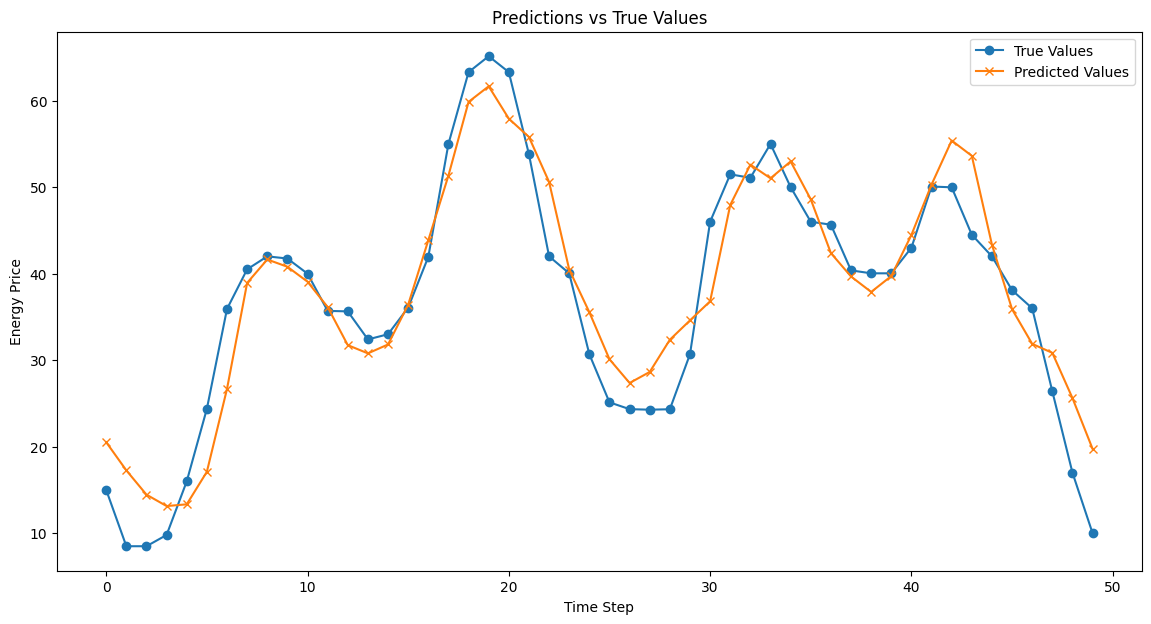

In [ ]:
# Plot predictions vs. true values for the test set
def plot_predictions(true_values, predicted_values, num_predictions=50):
    plt.figure(figsize=(14, 7))
    plt.plot(true_values[:num_predictions, 0], label='True Values', marker='o')
    plt.plot(predicted_values[:num_predictions, 0], label='Predicted Values', marker='x')
    plt.title('Predictions vs True Values')
    plt.xlabel('Time Step')
    plt.ylabel('Energy Price')
    plt.legend()
    plt.show()

# Visualize the results
plot_predictions(y_test_inverse, predictions_improved_inverse)


**Análisis del Gráfico**  

* **Tendencias y Patrones:** Las predicciones del modelo mejorado muestran una
buena correspondencia con los valores reales, capturando las fluctuaciones en los precios de la energía.
Los picos y valles en las predicciones coinciden en gran medida con los picos y valles de los valores reales, lo que indica que el modelo puede predecir tanto aumentos como disminuciones en los precios de la energía.


* **Desviaciones:** Aunque las predicciones son generalmente precisas, hay algunas desviaciones menores donde las predicciones no coinciden exactamente con los valores reales. Estas discrepancias podrían ser investigadas y potencialmente mitigadas con más ajustes en el modelo o más datos de entrenamiento.

### Conclusiones de los Resultados Obtenidos

La reducción del MSE de 124.9854 a 71.2702 demuestra que los ajustes realizados en el modelo han mejorado considerablemente su rendimiento.
A pesar de las mejoras logradas, siempre hay margen para optimizar aún más el modelo.